In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

#click 'Choose Files' then upload the 'dataset-of-00s.csv" file submitted to dropbox

Saving dataset-of-00s.csv to dataset-of-00s.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset-of-00s.csv']))
df = df[df['speechiness'] <= 0.66].reset_index() # Filter out speechiness > 0.66
df.head()

,index,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


In [ ]:
cols = ['danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'chorus_hit']

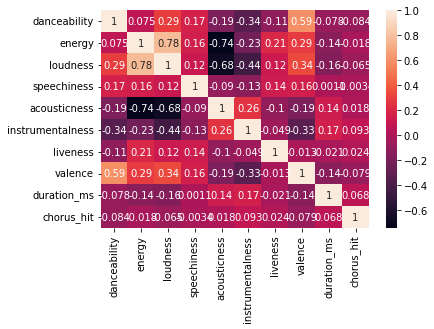

In [ ]:
sns.heatmap(df[cols].corr(), annot=True)

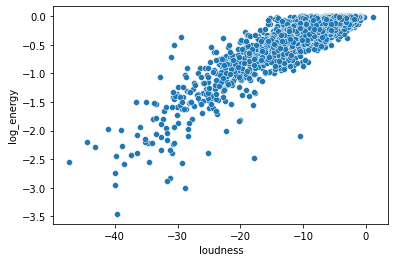

In [ ]:
# Observation : loudness vs log_enery
df2 = df[cols].copy()
df2['log_energy'] = df['energy'].transform(lambda x : np.log10(x))
sns.scatterplot(data=df2, x='loudness', y='log_energy')

In [ ]:
df2[['log_energy', 'loudness']].corr()

,log_energy,loudness
log_energy,1.000000,0.872983
loudness,0.872983,1.000000


In [ ]:
# Remove Outliers
# identify outliers in the training dataset

from sklearn.neighbors import LocalOutlierFactor


lof = LocalOutlierFactor(contamination=0.05) # 5% of the data are outliers
yhat = lof.fit_predict(df[cols].values) # outliers are labelled -1, inliers +1

df = df[yhat != -1].reset_index() # remove outliers

In [ ]:
# 1. Features are not not highly correlated
# 2. 10 features is too high for k-means to be useful ( curse of dimensionalityy )
#  ===> Use PCA to reduce the dimensionality of the data
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df[cols].values)

X_transformed = PCA(n_components=5).fit_transform(X_scaled)

# pca.explained_variance_ratio_ # [0.31263491, 0.15081743, 0.10921459, 0.10014063, 0.09218141,
                                #  0.07848179, 0.07034409, 0.04366301, 0.02810101, 0.01442112]   # 5 top components -> 75% of the variance is explained


In [ ]:
X_transformed.shape # Data is reduced to 5 dimensions

(5567, 5)

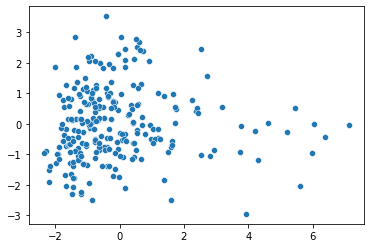

In [ ]:
# Visualize the first two componets of the data .. 
indices = np.random.choice(X_transformed.shape[0], 250, replace=False)
sns.scatterplot(x= X_transformed[indices,0], y=X_transformed[indices, 1])

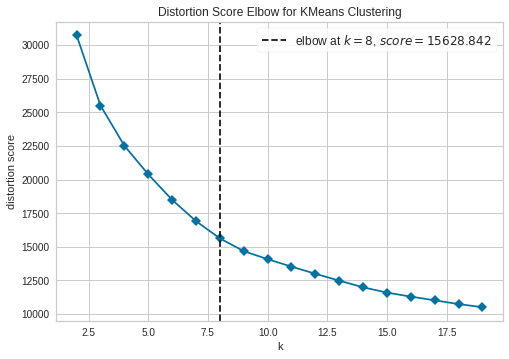

In [ ]:
# Cluster using K-means (https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

X = X_transformed
# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20), timings=False)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
clusters = KMeans(n_clusters=8, random_state=0).fit_predict(X_transformed)
df['clusters'] = clusters

In [ ]:
df[df['artist'] == 'Lady Gaga'] # All of Lady Gaga's songs fall into Cluster index=1 ( they're more or less similar ). Maybe this is 'PoP/Dance music' ? 

,level_0,index,track,artist,uri,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,clusters
1215,1279,1282,Poker Face,Lady Gaga,spotify:track:0WfKDYeUAoLA3vdvLKKWMW,0.851,0.806,4,-4.618,1,...,0.000001,0.1210,0.776,119.001,237200,4,25.37224,10,1,5
4185,4412,4423,Bad Romance,Lady Gaga,spotify:track:4rJjQvXxNxManKS805uHpu,0.696,0.921,0,-3.755,1,...,0.000052,0.0842,0.714,119.001,294573,4,26.04353,11,1,5
4623,4873,4884,Paparazzi,Lady Gaga,spotify:track:1YCfOBGw3qik62hWOW43A1,0.762,0.692,5,-3.973,0,...,0.000000,0.0940,0.397,114.906,208307,4,36.66640,9,1,5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 181, in _repr_mimebundle_
    dataframe = self._preprocess_dataframe()
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 169, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 5799, in reset_index
    new_obj.insert(0, name, level_values)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 4414, in insert
    raise ValueError(f"cannot insert {column}, already exists")
ValueError: cannot insert level_0, already exists
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 193, in _repr_javascript_module_
    return self._gen_js(self._preprocess

In [ ]:
df[df['artist'].str.contains("Guetta")] # David Guetta  is also in the same cluster


,level_0,index,track,artist,uri,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,clusters
384,410,410,When Love Takes Over,David Guetta Featuring Kelly Rowland,spotify:track:77FULy278MulVvGWS8BfK7,0.674,0.862,11,-4.614,1,...,0.000427,0.1690,0.500,129.965,191000,4,22.89914,8,1,5
1260,1327,1330,When Love Takes Over (feat. Kelly Rowland),David Guetta,spotify:track:77FULy278MulVvGWS8BfK7,0.674,0.862,11,-4.614,1,...,0.000427,0.1690,0.500,129.965,191000,4,22.89914,8,0,5
3200,3384,3392,Sexy Bitch (feat. Akon),David Guetta,spotify:track:0uXO2GrNiIb1xHT9LUdxZE,0.813,0.627,11,-5.018,0,...,0.000616,0.1310,0.801,130.011,195853,4,30.02278,9,0,5
5341,5626,5638,Gettin' Over You (feat. Fergie & LMFAO),David Guetta,spotify:track:6FbGlkHKGkYqpSCuBgurn3,0.620,0.870,10,-6.520,0,...,0.000000,0.0705,0.513,130.079,187427,4,38.05592,9,0,5


In [ ]:
# Distribution of Cluster 
df['clusters'].value_counts()

5    1542
0    1400
1     695
7     615
2     440
3     355
6     328
4     192
Name: clusters, dtype: int64

In [ ]:
df[df['artist'] == "Nickelback"] # Majority of Nickelback songs are cluster-0. Maybe cluster 0 is rock ? 

,level_0,index,track,artist,uri,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,clusters
184,197,197,Too Bad,Nickelback,spotify:track:2cCWbBmadLbKvr9xddC79R,0.598,0.808,10,-5.209,1,...,0.000000,0.147,0.288,128.025,232240,4,34.01039,11,1,0
262,281,281,If Today Was Your Last Day,Nickelback,spotify:track:4QJLKU75Rg4558f4LbDBRi,0.485,0.911,3,-5.749,1,...,0.000000,0.092,0.568,89.956,249067,4,38.52060,7,1,0
470,501,501,Feelin' Way Too Damn Good,Nickelback,spotify:track:4i2WUspbfNZCnhkypoFKrM,0.510,0.818,5,-5.626,1,...,0.000659,0.151,0.395,156.050,256453,4,27.13306,15,1,0
901,955,956,Photograph,Nickelback,spotify:track:3hb2ScEVkGchcAQqrPLP0R,0.513,0.877,8,-3.756,1,...,0.000163,0.136,0.389,145.919,258920,4,56.84924,11,1,0
1586,1678,1681,Someday,Nickelback,spotify:track:4PkJ7c9y1CwpuVOiJODnCZ,0.455,0.858,11,-5.659,0,...,0.000247,0.226,0.597,163.118,207467,4,59.09553,8,1,0
2390,2532,2537,If Everyone Cared,Nickelback,spotify:track:44w63XqGr3sATAzOnOySgF,0.522,0.874,6,-4.392,0,...,0.005790,0.261,0.196,132.018,215106,4,30.74400,10,1,0
2577,2728,2734,Never Gonna Be Alone,Nickelback,spotify:track:7aySoZnwt7c6lA54qVVUOk,0.544,0.802,4,-4.152,1,...,0.000073,0.122,0.590,130.022,227027,4,58.11086,7,1,5
3232,3418,3426,How You Remind Me,Nickelback,spotify:track:0gmbgwZ8iqyMPmXefof8Yf,0.446,0.764,10,-5.042,1,...,0.000000,0.099,0.543,172.094,223840,4,63.09937,6,1,0
3398,3590,3599,Far Away,Nickelback,spotify:track:0ADZ5dmXhlfzjMw6lefoPl,0.518,0.797,6,-5.153,1,...,0.000000,0.107,0.293,132.915,238173,4,37.16623,9,1,0
4322,4558,4569,Gotta Be Somebody,Nickelback,spotify:track:06T10fEzN8ZCcqzQZYA184,0.536,0.890,0,-5.222,1,...,0.001650,0.133,0.205,115.998,252653,4,39.18066,7,1,0


In [ ]:
df[df['clusters'] == 0] # Also rock songs 

,level_0,index,track,artist,uri,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,clusters
2,2,2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,...,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,0
8,8,8,Nothin' To Die For,Tim McGraw,spotify:track:3lRSz6HujrSy9b3LXg2Kq9,0.481,0.786,10,-5.654,1,...,0.000000,0.0759,0.389,153.105,253640,4,19.65701,11,1,0
11,11,11,Amarillo Sky,Jason Aldean,spotify:track:0axUHkhMMY0YSC1jFBVWqv,0.491,0.776,2,-3.887,1,...,0.000000,0.1460,0.428,154.988,202547,4,37.86861,9,1,0
12,12,12,Gin And Juice,Hot Rod Circuit,spotify:track:1xthH0Ze4FYo2y99QuJUUj,0.455,0.737,1,-6.206,1,...,0.000487,0.1950,0.206,94.028,224053,4,62.77759,9,0,0
17,17,17,Move Along,The All-American Rejects,spotify:track:2l57cfmCnOkwNX1tky02n1,0.518,0.916,3,-3.858,1,...,0.000000,0.2910,0.646,109.864,238880,4,19.81215,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547,5840,5852,Twisted Transistor,Korn,spotify:track:77VW8u6inET54YAKN1RSnd,0.580,0.983,5,-3.291,0,...,0.006940,0.0801,0.416,110.053,188933,4,34.92516,7,1,0
5549,5842,5854,Honkytonk U,Toby Keith,spotify:track:5bS3tVEOQ62Tn6ilUlJ2dB,0.640,0.762,9,-4.358,1,...,0.000053,0.3310,0.545,113.014,214107,4,65.02078,11,1,0
5552,5845,5857,Hearts On Fire,Cut Copy,spotify:track:0pAisVoZ7Gybjvm0q7AoVu,0.558,0.957,10,-3.999,0,...,0.868000,0.2310,0.683,124.978,292547,4,29.79587,10,0,0
5561,5854,5866,Shindo-kaku,ASIAN KUNG-FU GENERATION,spotify:track:1lzVhHihby5uHDwml2ApDr,0.323,0.953,9,-4.278,1,...,0.377000,0.0524,0.576,184.884,147200,4,21.98975,8,0,0


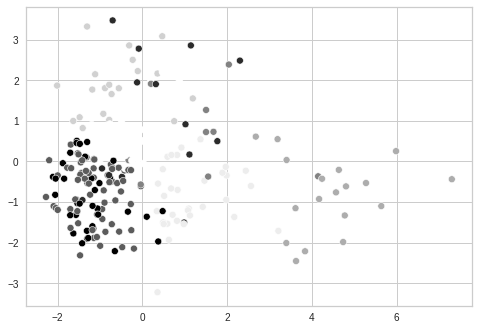

In [ ]:
# Visualize the clusters  ( only 1st two dims )
indices = np.random.choice(X_transformed.shape[0], 250, replace=False)
sns.scatterplot(x= X_transformed[indices,0], y=X_transformed[indices, 1], c=df["clusters"][indices])

In [ ]:
# Quick Check : Do we see a relationship between the 'cluster_index' and the 'target'  ?? 
# NOTE: This falls outside the scope of this 'unsupervised' analysis
df.groupby("clusters")["target"].value_counts()

clusters  target
0         0          791
          1          609
1         0          367
          1          328
2         0          354
          1           86
3         0          352
          1            3
4         0          189
          1            3
5         1         1182
          0          360
6         0          201
          1          127
7         1          470
          0          145
Name: target, dtype: int64